# Импорт библиотек

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/MTS ML Cup

/content/drive/MyDrive/MTS ML Cup


In [3]:
import sys
sys.path.insert(0, '/content/drive/MyDrive/MTS ML Cup/src')

import os
import warnings
os.environ['OPENBLAS_NUM_THREADS'] = '1'
warnings.filterwarnings('ignore');

In [ ]:
!pip install catboost

In [ ]:
!pip install lightgbm

In [ ]:
!pip install xgboost

In [7]:
import pandas as pd
import numpy as np
import bisect

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import sklearn.metrics as m
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize

In [8]:
from src.metric_functions import get_metrics_classification, get_metrics_multiclass, check_overfitting_classification, check_overfitting_multiclass

In [9]:
import seaborn as sns

%matplotlib inline
sns.set_style('darkgrid')

In [10]:
RAND = 42

final_types = {
    'user_id': 'int32',
    'part_of_day_day': 'int16',
    'part_of_day_night': 'int16',
    'day_pct': 'float32',
    'evening_pct': 'float32',
    'morning_pct': 'float32',
    'night_pct': 'float32',
    'act_days': 'int16',
    'avg_req_per_day': 'float32',
    'requests_std': 'float32',
    'act_days_pct': 'float32',
    'cpe_type_cd': 'category',
    'cpe_model_os_type': 'category',
    'cpe_manufacturer_name': 'category',
    'price': 'float32',
    'region_cnt': 'int8',
    'city_cnt': 'int8',
    'url_host_cnt': 'int16',
}

# Описание задачи

**В данном jupyter-ноутбуке мы обучим бейзлайн модели на данных, которые мы аггрегировали в Data_preprocession.ipnb и созданных на основании url, региона, города и модели телефона эмбеддингах, которые мы создали в create_embeddings.ipnb. Сравним модели, обученные без эмбеддингов и с ними**

## О соревновании и данных

https://ods.ai/competitions/mtsmlcup

Задача соревнования
- Определение пола и возраста владельца HTTP cookie по истории активности пользователя в интернете на основе синтетических данных.

Метрики соревнования:
* ROC-AUC – для определения пола, f1 weighted – для определения возраста.
* Все решения рассчитываются по формуле -  2 * f1_weighted(по 6 возрастным бакетам) + gini по полу.
* Возрастные бакеты (Класс 1 — 19-25, Класс 2 — 26-35, Класс 3 — 36-45, Класс 4 — 46-55, Класс 5 — 56-65, Класс 6 — 66+).

Предобработка, аггрегация и создание новых фич произведена в 0.Data_preparing.ipng.
Описание колонок аггрегированного файла с данными:
* 'part_of_day_day' – кол-во визитов пользователя днем
* 'part_of_day_evening' – кол-во визитов пользователя вечером
* 'part_of_day_morning' – кол-во визитов пользователя утром
* 'part_of_day_night' – кол-во визитов пользователя ночью
* 'sum_visits' – кол-во визитов пользователя
* 'day_pct' – доля визитов пользователя днем
* 'evening_pct' – доля визитов пользователя вечером
* 'morning_pct' – доля визитов пользователя утром
* 'night_pct' – доля визитов пользователя ночью
* 'act_days' – кол-во дней, в которые пользователь совершил визит пользователя
* 'request_cnt' - кол-во запросов пользователя
* 'avg_req_per_day' - среднее кол-во запросов пользователя
* 'period_days' - кол-во дней между первым и последним визитом пользователя
* 'request_std' - стандартное отклонение по количеству запросов
* 'act_days_pct' - доля дней, когда пользователь совершал визит
* 'cpe_type_cd - тип устройства
* 'cpe_model_os_type' - операционная система устройства
* 'cpe_manufacturer_name' -производитель устройства
* 'price' - цена устройства пользователя
* 'region_cnt' - кол-во уникальных регионов, из которых был совершен визит
* 'city_cnt' - кол-во уникальных городов, из которых был совершен визит
* 'url_host_cnt' - кол-во уникальных ссылок, с которых был совершен визит
* 'user_id' – ID пользователя

* также сгенерированы 300 признаков - эмбеддингов на основании региона, города, url и модели телефона

Описание колонок файла с таргетами:

* 'age' – Возраст пользователя
* 'is_male' – Признак пользователя : мужчина (1-Да, 0-Нет)
* 'user_id' – ID пользователя

## Структура проекта

Данная работа была разделена на несколько jupyter ноутбуков:

0. Data_preparing.ipnb - аггрегация отдельных файлов по user_id и склейка в финальный датасет
1. EDA.ipynb - исследовательская часть
2. baseline.ipynb - бейзлайн модели
3. create_embeddings.ipynb - создание эмбеддингов для дальнейшего их использования в качестве фич
4. baseline_embeddings.ipynb - бейзлан модели с эмбеддингами
5. model_tuning.ipynb - тюнинг наиболее перспективных моделей
6. gender_prediction_stacking.ipynb - стекинг моделей для предсказания пола


# Сбор всех данных

In [11]:
# id пользователей, которым нужно предсказать пол и возраст
id_to_submit = pd.read_parquet('submit.pqt')

# таргеты для обучения моделей
targets = pd.read_parquet('public_train.pqt')

# предобработанные нами данные
df = pd.read_csv('data_agg/df_final.csv')

In [16]:
df.head(3)

,user_id,part_of_day_day,part_of_day_night,day_pct,evening_pct,morning_pct,night_pct,act_days,avg_req_per_day,requests_std,act_days_pct,cpe_type_cd,cpe_model_os_type,cpe_manufacturer_name,price,region_cnt,city_cnt,url_host_cnt
0,4,199,10,0.336717,0.287648,0.358714,0.016920,20,38.850000,0.647632,0.4650,smartphone,Android,Huawei,12990.0,5,9,108
1,16,443,137,0.359870,0.260764,0.268075,0.111292,64,39.515625,1.397836,0.8647,smartphone,Android,Samsung,9583.0,1,1,50
2,18,566,34,0.503111,0.101333,0.365333,0.030222,32,60.937500,1.204972,0.8423,smartphone,Android,Samsung,22887.0,1,2,141


In [12]:
df = df.astype(final_types)
df.dtypes

user_id                     int32
part_of_day_day             int16
part_of_day_night           int16
day_pct                   float32
evening_pct               float32
morning_pct               float32
night_pct                 float32
act_days                    int16
avg_req_per_day           float32
requests_std              float32
act_days_pct              float32
cpe_type_cd              category
cpe_model_os_type        category
cpe_manufacturer_name    category
price                     float32
region_cnt                   int8
city_cnt                     int8
url_host_cnt                int16
dtype: object

In [18]:
df.shape

(415317, 18)

In [13]:
# загружаем созданные по url эмбеддинги
url_emb = pd.read_csv('embeddings/url_emb.csv')
url_emb = url_emb.add_suffix('_url').rename(columns={'user_id_url': 'user_id'})

In [14]:
# загружаем созданные по регионам эмбеддинги
reg_emb = pd.read_csv('embeddings/reg_emb.csv')
reg_emb = reg_emb.add_suffix('_reg').rename(columns={'user_id_reg': 'user_id'})

In [15]:
# загружаем созданные по городам эмбеддинги
city_emb = pd.read_csv('embeddings/city_emb.csv')
city_emb = city_emb.add_suffix('_city').rename(columns={'user_id_city': 'user_id'})

In [16]:
# загружаем созданные по девайсам эмбеддинги
model_emb = pd.read_csv('embeddings/model_emb.csv')
model_emb = model_emb.add_suffix('_model').rename(
    columns={'user_id_model': 'user_id'})

In [17]:
# загружаем метрики бейзлайном без эмбеддингов
metrics_gender_baseline = pd.read_csv('metrics/metrics_gender_baseline.csv')
metrics_age_baseline = pd.read_csv('metrics/metrics_age_baseline.csv')

# Baseline gender prediction with embeddings

In [19]:
# создаем датасет для обучения модели
df_train = targets.merge(df, how='inner', on=['user_id']) \
                  .merge(url_emb, how='inner', on='user_id') \
                  .merge(city_emb, how='inner', on=['user_id']) \
                  .merge(reg_emb, how='inner', on=['user_id']) \
                  .merge(model_emb, how='inner', on=['user_id'])

# удаляем пропуски
df_train = df_train[df_train['is_male'] != 'NA']
df_train = df_train.dropna()

df_train['is_male'] = df_train['is_male'].map(int)
df_train['is_male'].value_counts()

1    135331
0    128994
Name: is_male, dtype: int64

In [25]:
# сплит данных на train/validation/test
%%time
X = df_train.drop(['user_id', 'age', 'is_male'], axis=1)
y = df_train['is_male']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    stratify=y,
                                                    random_state=RAND)

X_train_, X_val, y_train_, y_val = train_test_split(X_train,
                                                    y_train,
                                                    test_size=0.16,
                                                    shuffle=True,
                                                    stratify=y_train,
                                                    random_state=RAND)

# значение для scale_pos_weight
ratio = float(np.sum(y == 0)) / np.sum(y == 1)

CPU times: user 1.06 s, sys: 390 ms, total: 1.45 s
Wall time: 1.44 s


## LGBM

In [26]:
# обучение бейзлайна LightGBM
%%time
lgbm_gender = LGBMClassifier(random_state=RAND, scale_pos_weight=ratio)
eval_set = [(X_val, y_val)]

lgbm_gender.fit(X_train,
                y_train,
                eval_metric='auc',
                eval_set=eval_set,
                early_stopping_rounds=100,
                verbose=False)

CPU times: user 1min 55s, sys: 1.16 s, total: 1min 56s
Wall time: 34.3 s


LGBMClassifier(random_state=42, scale_pos_weight=0.9531740695036613)

In [27]:
# итоговый балл соревнования считается по GINI по полу
# проверим какой GINI мы получили
print(
    f'GINI по полу {2 * m.roc_auc_score(y_test, lgbm_gender.predict_proba(X_test)[:,1]) - 1:2.3f}'
)

GINI по полу 0.623


In [28]:
# проверим не переобучилась ли наша модель
check_overfitting_classification(lgbm_gender, X_train, y_train, X_test, y_test)

ROC-AUC train = 0.835
ROC-AUC test = 0.812
delta = 2.85%


In [29]:
# получим итоговые метрики на тестовых данных
y_pred_test = lgbm_gender.predict(X_test)
y_score_test = lgbm_gender.predict_proba(X_test)

metrics_gender = metrics_gender_baseline.append(
    get_metrics_classification(y_test,
                               y_pred_test,
                               y_score_test,
                               name='LGBMBaseline_embeddings'))
metrics_gender

,model,Precision,Recall,f1,ROC_AUC,GINI
0,LGBMBaseline,0.607814,0.564989,0.585620,0.628592,0.257185
1,CatBoostBaseline,0.611604,0.565913,0.587872,0.630034,0.260068
2,XGBoostBaseline,0.606800,0.555863,0.580216,0.623342,0.246683
3,RandomForestBaseline,0.584381,0.585569,0.584974,0.600485,0.200970
0,LGBMBaseline_embeddings,0.740106,0.719981,0.729905,0.811624,0.623249


## CatBoost

In [30]:
# обучение бейзлайна CatBoost
%%time
cat_features = X.select_dtypes('category').columns.tolist()
cat_gender = CatBoostClassifier(allow_writing_files=False,
                                random_state=RAND,
                                eval_metric="AUC",
                                cat_features=cat_features,
                                scale_pos_weight=ratio)
eval_set = [(X_val, y_val)]

cat_gender.fit(X_train_,
               y_train_,
               eval_set=eval_set,
               verbose=False,
               early_stopping_rounds=100)

CPU times: user 14min 4s, sys: 16.1 s, total: 14min 20s
Wall time: 4min 23s


In [31]:
# получим оценку GINI
print(
    f'GINI по полу {2 * m.roc_auc_score(y_test, cat_gender.predict_proba(X_test)[:,1]) - 1:2.3f}'
)

GINI по полу 0.688


In [32]:
# проверим не переобучилась ли наша модель
check_overfitting_classification(cat_gender, X_train, y_train, X_test, y_test)

ROC-AUC train = 0.893
ROC-AUC test = 0.844
delta = 5.79%


In [33]:
# получим итоговые метрики на тестовых данных
y_pred_test = cat_gender.predict(X_test)
y_score_test = cat_gender.predict_proba(X_test)

metrics_gender = metrics_gender.append(
    get_metrics_classification(y_test,
                               y_pred_test,
                               y_score_test,
                               name='CatBoostBaseline_embeddings'))
metrics_gender

,model,Precision,Recall,f1,ROC_AUC,GINI
0,LGBMBaseline,0.607814,0.564989,0.585620,0.628592,0.257185
1,CatBoostBaseline,0.611604,0.565913,0.587872,0.630034,0.260068
2,XGBoostBaseline,0.606800,0.555863,0.580216,0.623342,0.246683
3,RandomForestBaseline,0.584381,0.585569,0.584974,0.600485,0.200970
0,LGBMBaseline_embeddings,0.740106,0.719981,0.729905,0.811624,0.623249
0,CatBoostBaseline_embeddings,0.770574,0.748282,0.759264,0.843999,0.687998


## XGBoost

In [34]:
# сплит данных на train/validation/test с one hot encoding
%%time
X = pd.get_dummies(df_train.drop(['user_id', 'age', 'is_male'], axis=1))
y = df_train['is_male']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    stratify=y,
                                                    random_state=RAND)

X_train_, X_val, y_train_, y_val = train_test_split(X_train,
                                                    y_train,
                                                    test_size=0.16,
                                                    shuffle=True,
                                                    stratify=y_train,
                                                    random_state=RAND)

# значение для scale_pos_weight
ratio = float(np.sum(y == 0)) / np.sum(y == 1)

CPU times: user 1.65 s, sys: 351 ms, total: 2 s
Wall time: 1.99 s


In [35]:
# обучение бейзлайна XGBoost
%%time
xgb_gender = XGBClassifier(random_state=RAND, scale_pos_weight=ratio)
eval_set = [(X_val, y_val)]

xgb_gender.fit(X_train,
               y_train,
               eval_metric='auc',
               eval_set=eval_set,
               early_stopping_rounds=100,
               verbose=0)

CPU times: user 44min 14s, sys: 3.33 s, total: 44min 17s
Wall time: 12min 31s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [36]:
# получим оценку GINI
print(
    f'GINI по полу {2 * m.roc_auc_score(y_test, xgb_gender.predict_proba(X_test)[:,1]) - 1:2.3f}'
)

GINI по полу 0.641


In [37]:
# проверим не переобучилась ли наша модель
check_overfitting_classification(xgb_gender, X_train, y_train, X_test, y_test)

ROC-AUC train = 0.895
ROC-AUC test = 0.821
delta = 9.09%


In [38]:
# получим итоговые метрики на тестовых данных
y_pred_test = xgb_gender.predict(X_test)
y_score_test = xgb_gender.predict_proba(X_test)

metrics_gender = metrics_gender.append(
    get_metrics_classification(y_test,
                               y_pred_test,
                               y_score_test,
                               name='XGBoostBaseline_embeddings'))
metrics_gender

,model,Precision,Recall,f1,ROC_AUC,GINI
0,LGBMBaseline,0.607814,0.564989,0.585620,0.628592,0.257185
1,CatBoostBaseline,0.611604,0.565913,0.587872,0.630034,0.260068
2,XGBoostBaseline,0.606800,0.555863,0.580216,0.623342,0.246683
3,RandomForestBaseline,0.584381,0.585569,0.584974,0.600485,0.200970
0,LGBMBaseline_embeddings,0.740106,0.719981,0.729905,0.811624,0.623249
0,CatBoostBaseline_embeddings,0.770574,0.748282,0.759264,0.843999,0.687998
0,XGBoostBaseline_embeddings,0.745593,0.728294,0.736842,0.820728,0.641457


Вывод: самые высокие метрики у catboost с эмбеддингами

In [39]:
# сохраним метрики, чтобы в дальнейшем сравнивать их с моделями на тюнинге
metrics_gender.to_csv('metrics/metrics_gender_embeddings.csv', index=False)

# Baseline age prediction with embeddings

In [20]:
def age_bucket(x):
    """Функция для создания бакетов по возрасту"""
    return bisect.bisect_left([18, 25, 35, 45, 55, 65], x)

## LGBM

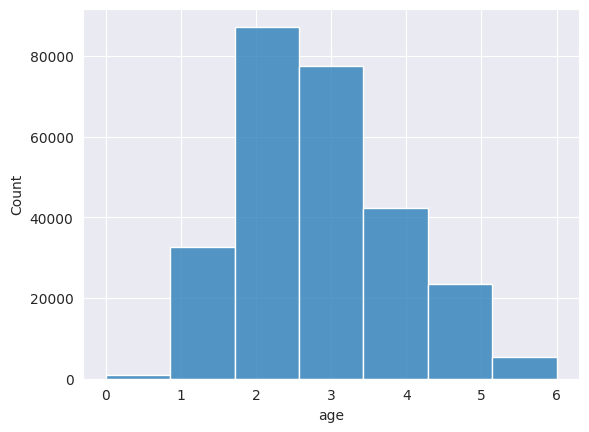

In [21]:
df_trn = targets.merge(df, how='inner', on=['user_id']) \
    .merge(url_emb, how='inner', on='user_id') \
    .merge(model_emb, how='inner', on=['user_id']) \
    .merge(reg_emb, how='inner', on=['user_id']) \
    .merge(city_emb, how='inner', on=['user_id'])

# удаляем пропущенные значения
df_trn = df_trn[df_trn['age'] != 'NA']
df_trn = df_trn.dropna()

# создаем бакеты по возрасту
df_trn['age'] = df_trn['age'].map(age_bucket)
sns.histplot(df_trn['age'], bins=7);

In [22]:
# по условиям соревнования в тестовых данных нет людей младше 19 лет
# поэтому можем удалить бакет 0
df_trn = df_trn.query('age > 0')

In [23]:
# разбивка данных на train/validation/test
X = df_trn.drop(['age', 'is_male', 'user_id'], axis=1)
y = df_trn['age']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    stratify=y,
                                                    random_state=RAND)

X_train_, X_val, y_train_, y_val = train_test_split(X_train,
                                                    y_train,
                                                    test_size=0.16,
                                                    shuffle=True,
                                                    stratify=y_train,
                                                    random_state=RAND)

n_classes = len(set(y))
y_train_bin = label_binarize(y_train, classes=list(set(y)))
y_test_bin = label_binarize(y_test, classes=list(set(y)))

In [24]:
# обучение бейзлайна LightGBM
%%time
lgbm_age = LGBMClassifier(random_state=RAND,
                          class_weight='balanced',
                          objective='multiclass')
eval_set = [(X_val, y_val)]

lgbm_age.fit(X_train_,
             y_train_,
             eval_set=eval_set,
             early_stopping_rounds=100,
             verbose=False)

CPU times: user 7min 23s, sys: 1.48 s, total: 7min 25s
Wall time: 2min 3s


LGBMClassifier(class_weight='balanced', objective='multiclass', random_state=42)

In [25]:
# проверим модель на переобучение
check_overfitting_multiclass(lgbm_age, X_train, y_train, X_test, y_test)

f1-weighted train = 0.443
f1-weighted test = 0.356
delta = 24.63%


In [26]:
print(
    m.classification_report(
        y_test,
        lgbm_age.predict(X_test),
        target_names=['19-25', '26-35', '36-45', '46-55', '56-65', '66+']))

              precision    recall  f1-score   support

       19-25       0.35      0.66      0.46      6528
       26-35       0.50      0.35      0.41     17454
       36-45       0.43      0.28      0.34     15497
       46-55       0.30      0.23      0.26      8489
       56-65       0.22      0.36      0.28      4716
         66+       0.08      0.39      0.13      1101

    accuracy                           0.35     53785
   macro avg       0.32      0.38      0.31     53785
weighted avg       0.40      0.35      0.36     53785



In [27]:
# получим итоговые метрики на тестовых данных
y_pred = lgbm_age.predict(X_test)
y_score = lgbm_age.predict_proba(X_test)

metrics_age = metrics_age_baseline.append(
    get_metrics_multiclass(y_test_bin=y_test_bin,
                           y_test=y_test,
                           y_pred=y_pred,
                           y_prob=y_score,
                           name='LGBM_Baseline_embeddings',
                           type_multi='ovo'))
metrics_age

,model,ROC_AUC,Precision_micro,Precision_macro,Recall_micro,Recall_macro,F1_micro,F1_macro,F1_weighted,Logloss
0,LGBM_Baseline,0.663449,0.239119,0.237250,0.239119,0.292757,0.239119,0.218909,0.246096,1.660580
1,CatBoost_Baseline,0.675669,0.365381,0.320267,0.365381,0.224303,0.365381,0.216226,0.321252,1.463261
2,RandomForest_Baseline,0.634683,0.347439,0.262835,0.347439,0.211312,0.347439,0.201186,0.303809,1.712283
0,LGBM_Baseline_embeddings,0.754989,0.350395,0.315773,0.350395,0.379041,0.350395,0.314327,0.355704,1.466697


## Catboost

In [28]:
# обучение бейзлайна CatBoost
%%time
cat_features = X.select_dtypes('category').columns.tolist()
cat_age = CatBoostClassifier(allow_writing_files=False,
                             cat_features=cat_features,
                             random_state=RAND)
eval_set = [(X_val, y_val)]

cat_age.fit(X_train,
            y_train,
            eval_set=eval_set,
            early_stopping_rounds=100,
            verbose=False)

CPU times: user 1h 36min 23s, sys: 2min 33s, total: 1h 38min 57s
Wall time: 27min 33s


In [29]:
# проверим модель на переобучение
check_overfitting_multiclass(cat_age, X_train, y_train, X_test, y_test)

f1-weighted train = 0.526
f1-weighted test = 0.426
delta = 23.61%


In [30]:
print(
    m.classification_report(
        y_test,
        cat_age.predict(X_test),
        target_names=['19-25', '26-35', '36-45', '46-55', '56-65', '66+']))

              precision    recall  f1-score   support

       19-25       0.53      0.32      0.40      6528
       26-35       0.49      0.63      0.55     17454
       36-45       0.40      0.52      0.45     15497
       46-55       0.39      0.23      0.28      8489
       56-65       0.40      0.20      0.27      4716
         66+       0.42      0.02      0.04      1101

    accuracy                           0.45     53785
   macro avg       0.44      0.32      0.33     53785
weighted avg       0.44      0.45      0.43     53785



In [31]:
# получим итоговые метрики на тестовых данных
y_pred = cat_age.predict(X_test)
y_score = cat_age.predict_proba(X_test)

metrics_age = metrics_age.append(
    get_metrics_multiclass(y_test_bin=y_test_bin,
                           y_test=y_test,
                           y_pred=y_pred,
                           y_prob=y_score,
                           name='CatBoost_Baseline_embeddings',
                           type_multi='ovo'))
metrics_age

,model,ROC_AUC,Precision_micro,Precision_macro,Recall_micro,Recall_macro,F1_micro,F1_macro,F1_weighted,Logloss
0,LGBM_Baseline,0.663449,0.239119,0.237250,0.239119,0.292757,0.239119,0.218909,0.246096,1.660580
1,CatBoost_Baseline,0.675669,0.365381,0.320267,0.365381,0.224303,0.365381,0.216226,0.321252,1.463261
2,RandomForest_Baseline,0.634683,0.347439,0.262835,0.347439,0.211312,0.347439,0.201186,0.303809,1.712283
0,LGBM_Baseline_embeddings,0.754989,0.350395,0.315773,0.350395,0.379041,0.350395,0.314327,0.355704,1.466697
0,CatBoost_Baseline_embeddings,0.779631,0.445366,0.437807,0.445366,0.318597,0.445366,0.332238,0.425856,1.282605


Вывод: самые высокие метрики у catboost с эмбеддингами

In [32]:
# сохраним метрики, чтобы в дальнейшем сравнивать их с моделями на тюнинге
metrics_age.to_csv('metrics/metrics_age_embeddings.csv', index=False)